In [1]:
# import keras
import nle.dataset as nld
from nle.nethack import tty_render
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import ttest_ind


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from nle.dataset import db

In [2]:
# Data path
# Define data set in separate jupyter notebook, then write it into to this notebook
nld_nao_path = "/code/nld-nao/nld-nao-unzipped"

dbfilename = "nld-nao.db"

dataset_name = "nld-nao"

db_conn = nld.db.connect(filename=dbfilename)
print(f"AltOrg Dataset has {nld.db.count_games('nld-nao', conn=db_conn)} games.")

AltOrg Dataset has 1511228 games.


In [3]:
# X1 = [[1,2,3,4,5]] Y1 = [6]  
# X2 = [[2,3,4,5,6]] Y2 = [7] 
# Create a Y vector, convert forecasting problem to a supervised learning problem
# We are going to do a multivariate X vector

# Write a function to convert the inputs to vectors for learning
def df_to_x_y(df, window_size=5):
    df_as_np = df.to_numpy() 
    X = []
    y = []
    for i in range(len(df_as_np)- window_size):
        row = [[a] for a in df_as_np[i:i+5]]
        X.append(row)
        label = df_as_np[i+5]
        y.append(label)
    return np.array(X), np.array(y)

In [13]:
WINDOW_SIZE = 5

# temp = data['deathlev']
X1, y1 = df_to_x_y(temp, WINDOW_SIZE)
X1.shape, y1.shape

((9395, 5, 1), (9395,))

In [14]:
X_train1, y_train1 = X1[:5000], y1[:5000]
X_val1, y_val1 = X1[5000:6500], y1[5000:6500]
X_test1, y_test1 = X1[6500:], y1[6500:]
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, y_test1.shape

((5000, 5, 1), (5000,), (1500, 5, 1), (1500,), (2895,))

In [18]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import *
import tensorflow.keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.layers import InputLayer

# Load your dataset (replace with actual path or DataFrame)
# Assuming `data` is your DataFrame containing the relevant data
# Make sure to include relevant columns such as 'starttime', 'maxlvl', and other features


model1 = Sequential()
model1.add(InputLayer((5,1))) 
model1.add(LSTM(64, return_sequences=True))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 5, 64)          │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 5, 8)           │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5, 1)           │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,425 (68.07 KB)

 Trainable params: 17,425 (68.07 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Need to debug callbacks (not working with tensorflow) 
cp1 = tf.keras.ModelCheckpoint('model1/', save_best_only=True)
# model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=['mae'])

In [ ]:
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=['mae'])
model1.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=10, batch_size=128, verbose=2)

In [ ]:
from tensorflow.keras import load_model
model1 = load_model('model1/')

In [40]:
subselect_sql = """
SELECT * 
FROM games 
WHERE name IN (SELECT name FROM games WHERE death = 'ascended' GROUP BY name HAVING COUNT(*) = 1)"""


df = pd.read_sql(subselect_sql, db_conn)  

# Group by player name and calculate min starttime and max endtime
time_diff = df.groupby('name').agg(min_starttime=('starttime', 'min'), max_endtime=('endtime', 'max')
)

# Calculate the difference
time_diff['time_difference'] = time_diff['max_endtime'] - time_diff['min_starttime']

# print(time_diff.sort_values(by='time_difference', ascending=False))


# Merge the original DataFrame with the time difference DataFrame
df = pd.merge(df, time_diff, on='name')

# Group by player name and select the first ten unique players
first_ten_players = df['name'].unique()[:500]
# Filter the original DataFrame to include only the first ten players
ascended_df = df[df['name'].isin(first_ten_players)]

ascended_df = ascended_df.sort_values(by=['name','starttime'])
# Drop the column
ascended_df = ascended_df.drop('min_starttime', axis=1)
ascended_df = ascended_df.drop('max_endtime', axis=1)

# Build the subselect sql query
subselect_sql_1 = """
SELECT *
FROM games
WHERE name NOT IN (
    SELECT name
    FROM games
    WHERE death = 'ascended'
)"""

df = pd.read_sql(subselect_sql_1, db_conn) 

# Group by player name and calculate min starttime and max endtime
time_diff = df.groupby('name').agg(min_starttime=('starttime', 'min'), max_endtime=('endtime', 'max')
)

# Calculate the difference
time_diff['time_difference'] = time_diff['max_endtime'] - time_diff['min_starttime'] 

df = pd.merge(df, time_diff, on='name')

# Group by player name and select the first 25 unique players
first_ten_players = df['name'].unique()[:500]
# Filter the original DataFrame to include only the first ten players
non_ascended_df = df[df['name'].isin(first_ten_players)]

non_ascended_df = non_ascended_df.drop('min_starttime', axis=1)
non_ascended_df = non_ascended_df.drop('max_endtime', axis=1)

# Merge Data frames for Model Construction 

# Merge ascended and non-ascended players
# Merge the DataFrames on common columns (e.g., 'name' and 'starttime')
data = pd.merge(ascended_df, non_ascended_df, how = 'outer')

data = data.sort_values(by=['name','starttime'])
# Convert Unix time columns to human-readable datetime
data['starttime'] = pd.to_datetime(data['starttime'], unit='s')
data['endtime'] = pd.to_datetime(data['endtime'], unit='s')
data['time_difference'] = pd.to_datetime(data['time_difference'], unit='s')

# Group by player name and calculate min starttime and max endtime
time_diff = data.groupby('name').agg(min_starttime=('starttime', 'min'), max_endtime=('endtime', 'max')
)

# Calculate the difference
time_diff['time_difference'] = time_diff['max_endtime'] - time_diff['min_starttime']

# Merge the original DataFrame with the time difference DataFrame
data = pd.merge(data, time_diff, on='name')
# Delete the 'age' column
data = data.drop('time_difference_x', axis=1)
data = data.drop('min_starttime', axis=1)
data = data.drop('max_endtime', axis=1)

data

,gameid,version,points,deathdnum,deathlev,maxlvl,hp,maxhp,deaths,deathdate,...,conduct,turns,achieve,realtime,starttime,endtime,gender0,align0,flags,time_difference_y
0,3520378,3.4.3,0,0,1,1,0,10,1,20080322,...,0xfff,52,0x0,30,2008-03-22 00:07:04,2008-03-22 00:07:40,Fem,Neu,-1,3509 days 20:14:33
1,3520380,3.4.3,0,0,1,1,-1,11,1,20080322,...,0xfff,10,0x0,125,2008-03-22 00:07:43,2008-03-22 00:09:50,Mal,Cha,-1,3509 days 20:14:33
2,3520795,3.4.3,161,0,3,3,15,15,0,20080322,...,0xfcf,308,0x0,106,2008-03-22 22:12:31,2008-03-22 22:14:21,Fem,Cha,-1,3509 days 20:14:33
3,3521208,3.4.3,250,2,6,6,-17,13,1,20080323,...,0xfff,8,0x0,632,2008-03-23 11:21:37,2008-03-23 19:35:39,Mal,Cha,-1,3509 days 20:14:33
4,3521210,3.4.3,3,7,-5,1,16,16,0,20080323,...,0xdff,1,0xe0,46,2008-03-23 19:36:30,2008-03-23 19:37:24,Fem,Neu,-1,3509 days 20:14:33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188287,6536031,3.4.3,2912,2,4,4,-6,37,1,20171028,...,0xf80,2038,0x0,698,2017-10-28 18:01:48,2017-10-28 18:13:26,Mal,Cha,0x0,3996 days 05:15:29
188288,6536204,3.4.3,474,0,2,2,-4,27,1,20171030,...,0xfc8,1003,0x0,393,2017-10-30 11:01:08,2017-10-30 11:07:43,Mal,Cha,0x0,3996 days 05:15:29
188289,6536205,3.4.3,93,0,1,1,0,11,1,20171030,...,0xfc8,206,0x0,75,2017-10-30 11:07:46,2017-10-30 11:09:01,Mal,Cha,0x0,3996 days 05:15:29
188290,2782906,3.6.0,90,0,1,1,8,11,0,20171102,...,0xfcf,125,0x0,200,2017-11-02 09:45:57,2017-11-02 09:49:18,Mal,Cha,0x4,3996 days 05:15:29


In [41]:
# Set the index of the data frame to a pandas data time representation for time series forecasting
data.index = pd.to_datetime(data['starttime'], format='%d.%m.%Y %H:%M:%S')

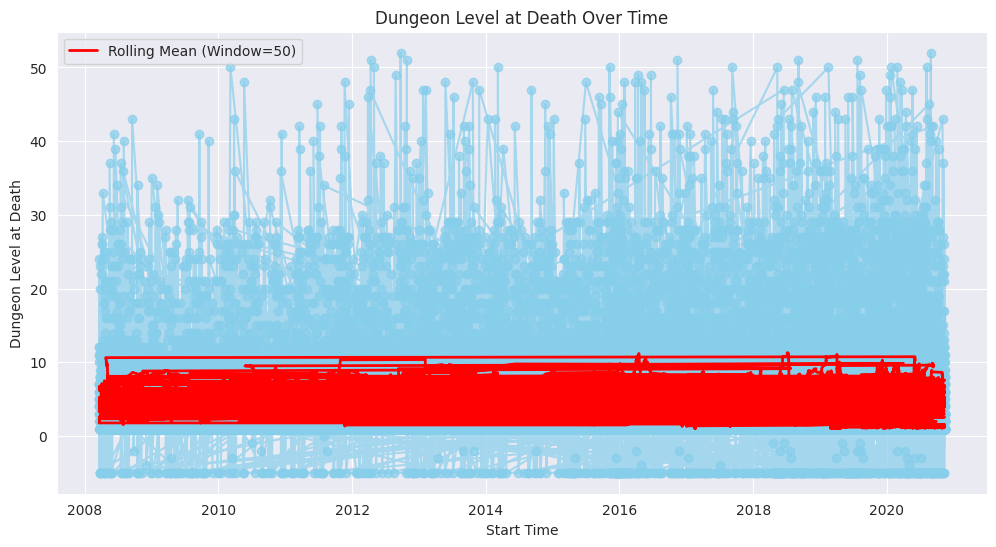

In [42]:
# Make a variable for Dungeon Level
import matplotlib.pyplot as plt

# Plot with better formatting
plt.figure(figsize=(12, 6))
plt.plot(data['starttime'], data['deathlev'], marker='o', linestyle='-', color='skyblue', alpha=0.7)

# Add a rolling mean to smooth out the noise
data['rolling_mean'] = data['deathlev'].rolling(window=50).mean()
plt.plot(data['starttime'], data['rolling_mean'], color='red', linewidth=2, label='Rolling Mean (Window=50)')

# Customize labels and title
plt.xlabel('Start Time')
plt.ylabel('Dungeon Level at Death')
plt.title('Dungeon Level at Death Over Time')
plt.grid(True)
plt.legend()

# Show the plot
plt.show()

In [43]:
temp = data.groupby('name')['points'].mean().reset_index()
# Rename the column 
temp.columns = ['name', 'points_mean']
# Implement rolling window average based on last five games
temp['points_rolling_mean_5'] = temp['points_mean'].transform(lambda x: x.rolling(window=5, min_periods=1).mean())

temp

,name,points_mean,points_rolling_mean_5
0,Player0,8.683810e+02,8.683810e+02
1,Player1,6.520144e+03,3.694262e+03
2,Player100,7.164450e+03,4.850992e+03
3,Player10016,9.439884e+04,2.723795e+04
4,Player10023,7.784875e+03,2.334734e+04
...,...,...,...
995,Player9910,4.627007e+04,5.138594e+05
996,Player9929,4.139016e+04,2.671729e+05
997,Player9967,1.807082e+06,4.353480e+05
998,Player998,3.163426e+06,1.012576e+06


       gameid version   points  deathdnum  deathlev  maxlvl   hp  maxhp  \
62033   64898   3.6.4  3585138          7        -5      46  237    285   

       deaths  deathdate  ...  conduct  turns achieve realtime  \
62033       1   20200314  ...      0x0  53163   0xdff    99009   

                starttime             endtime gender0 align0 flags  \
62033 2020-03-02 19:24:37 2020-03-14 10:57:30     Fem    Law   0x4   

       time_difference_y  
62033   11 days 15:32:53  

[1 rows x 28 columns]
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: rolling_std, dtype: float64


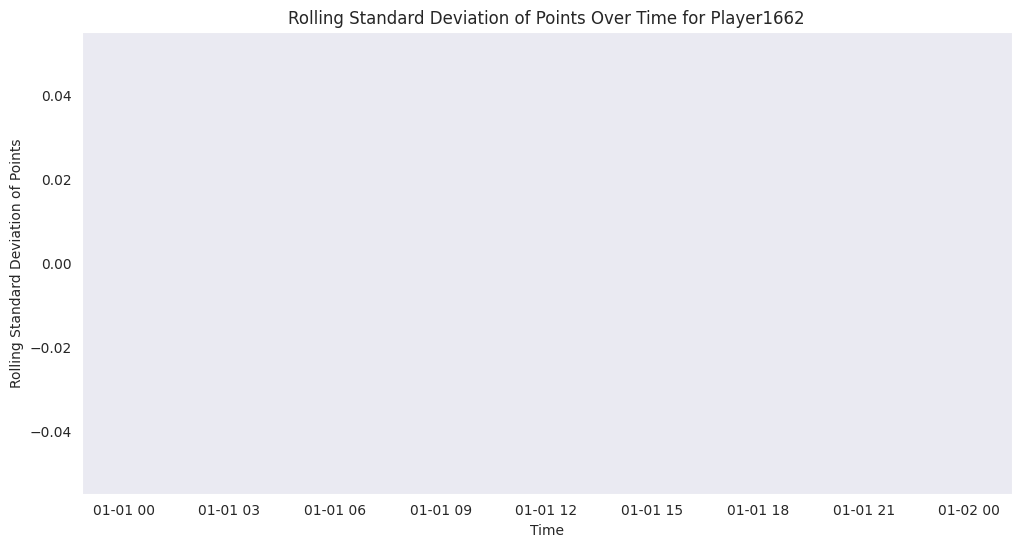

In [39]:
# Player Example 
player_name = 'Player1662' 
temp_df = data[data['name'] == player_name].copy()
print(temp_df)

# # Ensure 'starttime' is only a column
# if 'starttime' in temp_df.index.names:
#     temp_df = temp_df.reset_index()

# Sort by Time 
temp_df.sort_values('starttime', inplace=True)

# Rolling Standard Deviation
window_size = 10
temp_df['rolling_std'] = temp_df['points'].rolling(window=window_size).std()


print(temp_df['rolling_std'].describe())


# Rolling Window Plot
plt.figure(figsize=(12, 6))
plt.plot(temp_df['starttime'], temp_df['rolling_std'], marker='o', linestyle='-', color='b')
plt.title(f'Rolling Standard Deviation of Points Over Time for {player_name}')
plt.xlabel('Time')
plt.ylabel('Rolling Standard Deviation of Points')
plt.grid()
plt.show()

In [44]:
from sklearn.preprocessing import MinMaxScaler
# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Normalize columns
columns_to_normalize = ['points', 'maxlvl', 'turns', 'maxhp']

# Transform selected columns
data[columns_to_normalize] = scaler.fit_transform(data[columns_to_normalize])

# Ascension encoded to binary variable
data['death_encoded'] = data['death'].map({'ascended': 1}).fillna(0).astype(int)

agg_data = data.groupby('name').agg({
    'points': ['mean', 'max', 'min', 'sum', 'std']
    'turns': ['mean', 'max', 'min', 'sum', 'std'],
    'maxlvl': ['mean', 'max', 'min'],
    'death_encoded': 'mean'  # Proportion of games ascended
}).reset_index()


# Flatten columns 
agg_data.columns = ['_'.join(col).strip() for col in agg_data.columns.values]
agg_data = agg_data.rename(columns={'name_': 'name', 'death_encoded_mean': 'ascension_proportion'})

# append rolling mean from temp data frame
agg_data['rolling_mean'] =  temp['points_rolling_mean_5'].values

# Target variable: death 
agg_data['target'] = data.groupby('name')['death_encoded'].max().values

agg_data

,name,points_mean,points_max,points_min,points_sum,points_std,rolling_mean,target
0,Player0,0.000010,0.000112,0.000000e+00,0.000218,0.000028,8.683810e+02,1
1,Player1,0.000078,0.010905,0.000000e+00,0.042210,0.000523,3.694262e+03,0
2,Player100,0.000086,0.002026,4.777717e-08,0.042958,0.000235,4.850992e+03,0
3,Player10016,0.001128,0.048695,5.972146e-08,0.055249,0.006944,2.723795e+04,1
4,Player10023,0.000093,0.039127,0.000000e+00,0.079037,0.001367,2.334734e+04,1
...,...,...,...,...,...,...,...,...
995,Player9910,0.000553,0.051224,0.000000e+00,0.058030,0.004996,5.138594e+05,1
996,Player9929,0.000494,0.027595,0.000000e+00,0.040539,0.003096,2.671729e+05,1
997,Player9967,0.021584,0.043160,8.731278e-06,0.043169,0.030512,4.353480e+05,1
998,Player998,0.037785,0.074859,7.104943e-04,0.075570,0.052431,1.012576e+06,1


In [45]:
# NaN analysis
# Display rows that contain any NaN values
print(df[df.isna().any(axis=1)])

print(agg_data.dtypes)
# Drop NaN columns
# agg_data = agg_data.dropna()

Empty DataFrame
Columns: [gameid, version, points, deathdnum, deathlev, maxlvl, hp, maxhp, deaths, deathdate, birthdate, uid, role, race, gender, align, name, death, conduct, turns, achieve, realtime, starttime, endtime, gender0, align0, flags, min_starttime, max_endtime, time_difference]
Index: []

[0 rows x 30 columns]
name             object
points_mean     float64
points_max      float64
points_min      float64
points_sum      float64
points_std      float64
rolling_mean    float64
target            int64
dtype: object


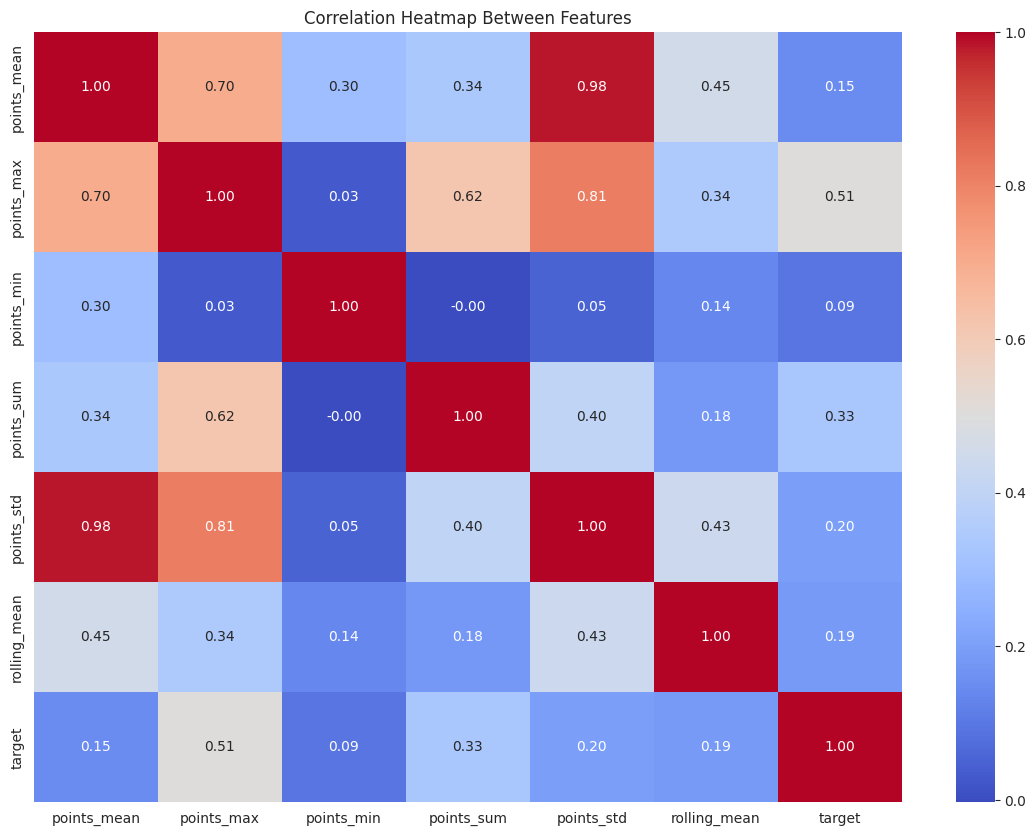

In [46]:
# Heat map of feature correlation to Target
corr = agg_data.drop(columns=['name']).corr()
# Set up the figure size before creating the heatmap
plt.figure(figsize=(14, 10))  # Adjust the width and height as needed
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap Between Features')
plt.show()

In [ ]:
# from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
# 
# # Logistic Regression Classification 
# model = LogisticRegression(max_iter=10000)
# model.fit(X_train, y_train)
# 
# # Predict on Test Set
# y_pred = model.predict(X_test)
# # Evaluation: 
# print("Accuracy:", accuracy_score(y_test, y_pred))
# print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
# print("Classification Report:\n", classification_report(y_test, y_pred, zero_division=0))

In [47]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Features 
X = agg_data.drop(columns=['name', 'target'])
y = agg_data['target']

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [48]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
# Initialize the RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred))

Accuracy: 0.95
Confusion Matrix:
 [[94  8]
 [ 2 96]]
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.92      0.95       102
           1       0.92      0.98      0.95        98

    accuracy                           0.95       200
   macro avg       0.95      0.95      0.95       200
weighted avg       0.95      0.95      0.95       200

ROC-AUC Score: 0.9505802320928372


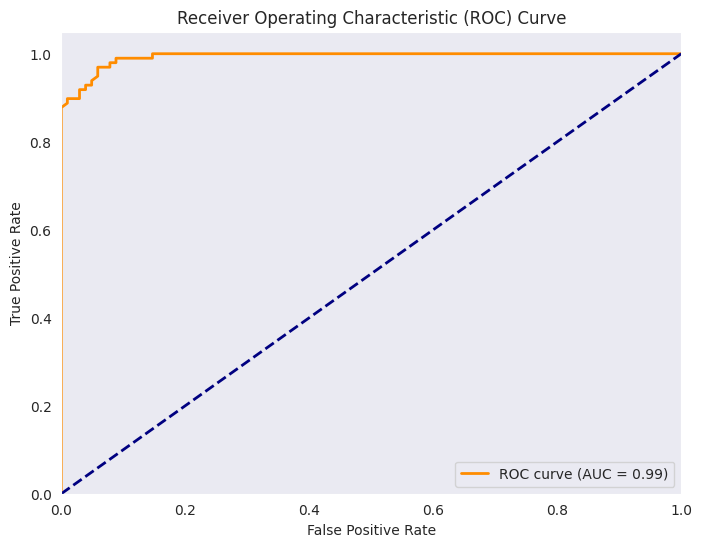

In [49]:
from sklearn.metrics import roc_curve, auc
# Predict probabilities for the positive class
y_prob = model.predict_proba(X_test)[:, 1]

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Calculate the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC AUC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()

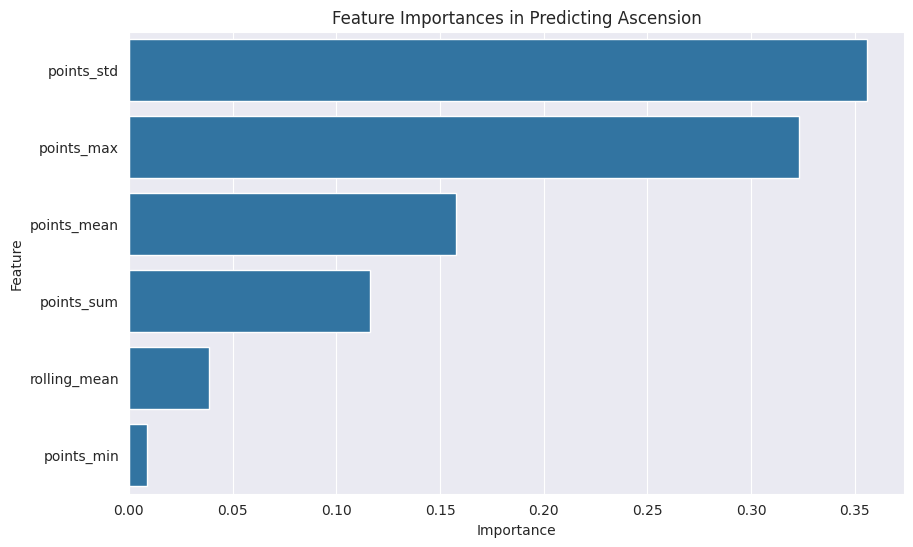

In [50]:
# Get feature importances
feature_importances = model.feature_importances_

# Create a DataFrame for visualization
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importances in Predicting Ascension')
plt.show()

In [51]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score

# Initialize with 5 folds
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# K Fold Cross Validation
cv_scores = cross_val_score(model, X, y, cv=kf, scoring='accuracy')

# Print results
print("Cross-Validation Scores:", cv_scores)
print("Mean Accuracy:", cv_scores.mean())
print("Standard Deviation of Accuracy:", cv_scores.std())

# How to debug and interpret these k-fold results to improve model performance
# Choosing test data - to find model that generlizes, don't focus on splits

Cross-Validation Scores: [0.95  0.97  0.99  0.975 0.98 ]
Mean Accuracy: 0.9730000000000001
Standard Deviation of Accuracy: 0.01326649916142161


In [14]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

# Initialize the Random Forest model
rf = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='accuracy')

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Best parameters
print("Best Parameters:", grid_search.best_params_)

Fitting 5 folds for each of 1620 candidates, totalling 8100 fits
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=400; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=400; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_esti

KeyboardInterrupt: 

In [ ]:
# Generate histograms to see ascended games and non ascended games because there should be different distributions
# One feature may be sufficient for nearly perfect accuracy - just points obtain the same accuracy
# What model can be can get with one features
# Why are they NAN - figure out what is happening here
# May have to change calculations to exclude errors 
# Further expanding the dataset - Need to clean up process for
# Generate folder for dataframes that can be loaded in 
# Investigate experimental weirdness 
# Forecasting model, finish LSTM - fixed simplicity 
# Filter out users who ascend many, many times
# Taking dataset we already have and doing the analysis we discussed
# Make dataset makes sense, then work on forecasting model. 
# Story: If I take a random user, can I predict if they will eventually ascend
# 